In [11]:
import random
import csv
import pickle
import json
import re
import time
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict, learning_curve
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, r2_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.dummy import DummyClassifier
from scipy.spatial import distance
import imblearn.over_sampling

In [12]:
df = pd.read_pickle('LoL_df.pkl')

In [19]:
df.head(5)

,Blue Winner,Match Length,Winner First Blood,Winner First Tower,Winner First Inhibitor,Winner First Baron,Winner First Dragon,Winner First Herald,Blue Tower Kills,Blue Inhibitor Kills,Blue Baron Kills,Blue Dragon Kills,Blue Rift Herald Kills,Red Tower Kills,Red Inhibitor Kills,Red Baron Kills,Red Dragon Kills,Red Rift Herald Kills
gameId,,,,,,,,,,,,,,,,,,
3508539941,0,35.3,0,0,1,1,1,0,4,0,0,2,1,6,1,1,2,0
3510680882,0,30.9,1,0,1,1,0,0,7,2,0,2,1,5,2,1,1,0
3510731607,1,29.0,1,1,1,1,1,1,10,2,1,2,1,1,0,0,1,0
3512273966,0,23.1,1,1,1,1,0,1,0,0,0,1,0,9,1,1,1,1
3514387059,0,31.0,1,1,1,1,1,1,3,0,0,0,0,8,1,1,3,1


In [14]:
y = df['Blue Winner']
X = df.iloc[:,1:]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 8675309)

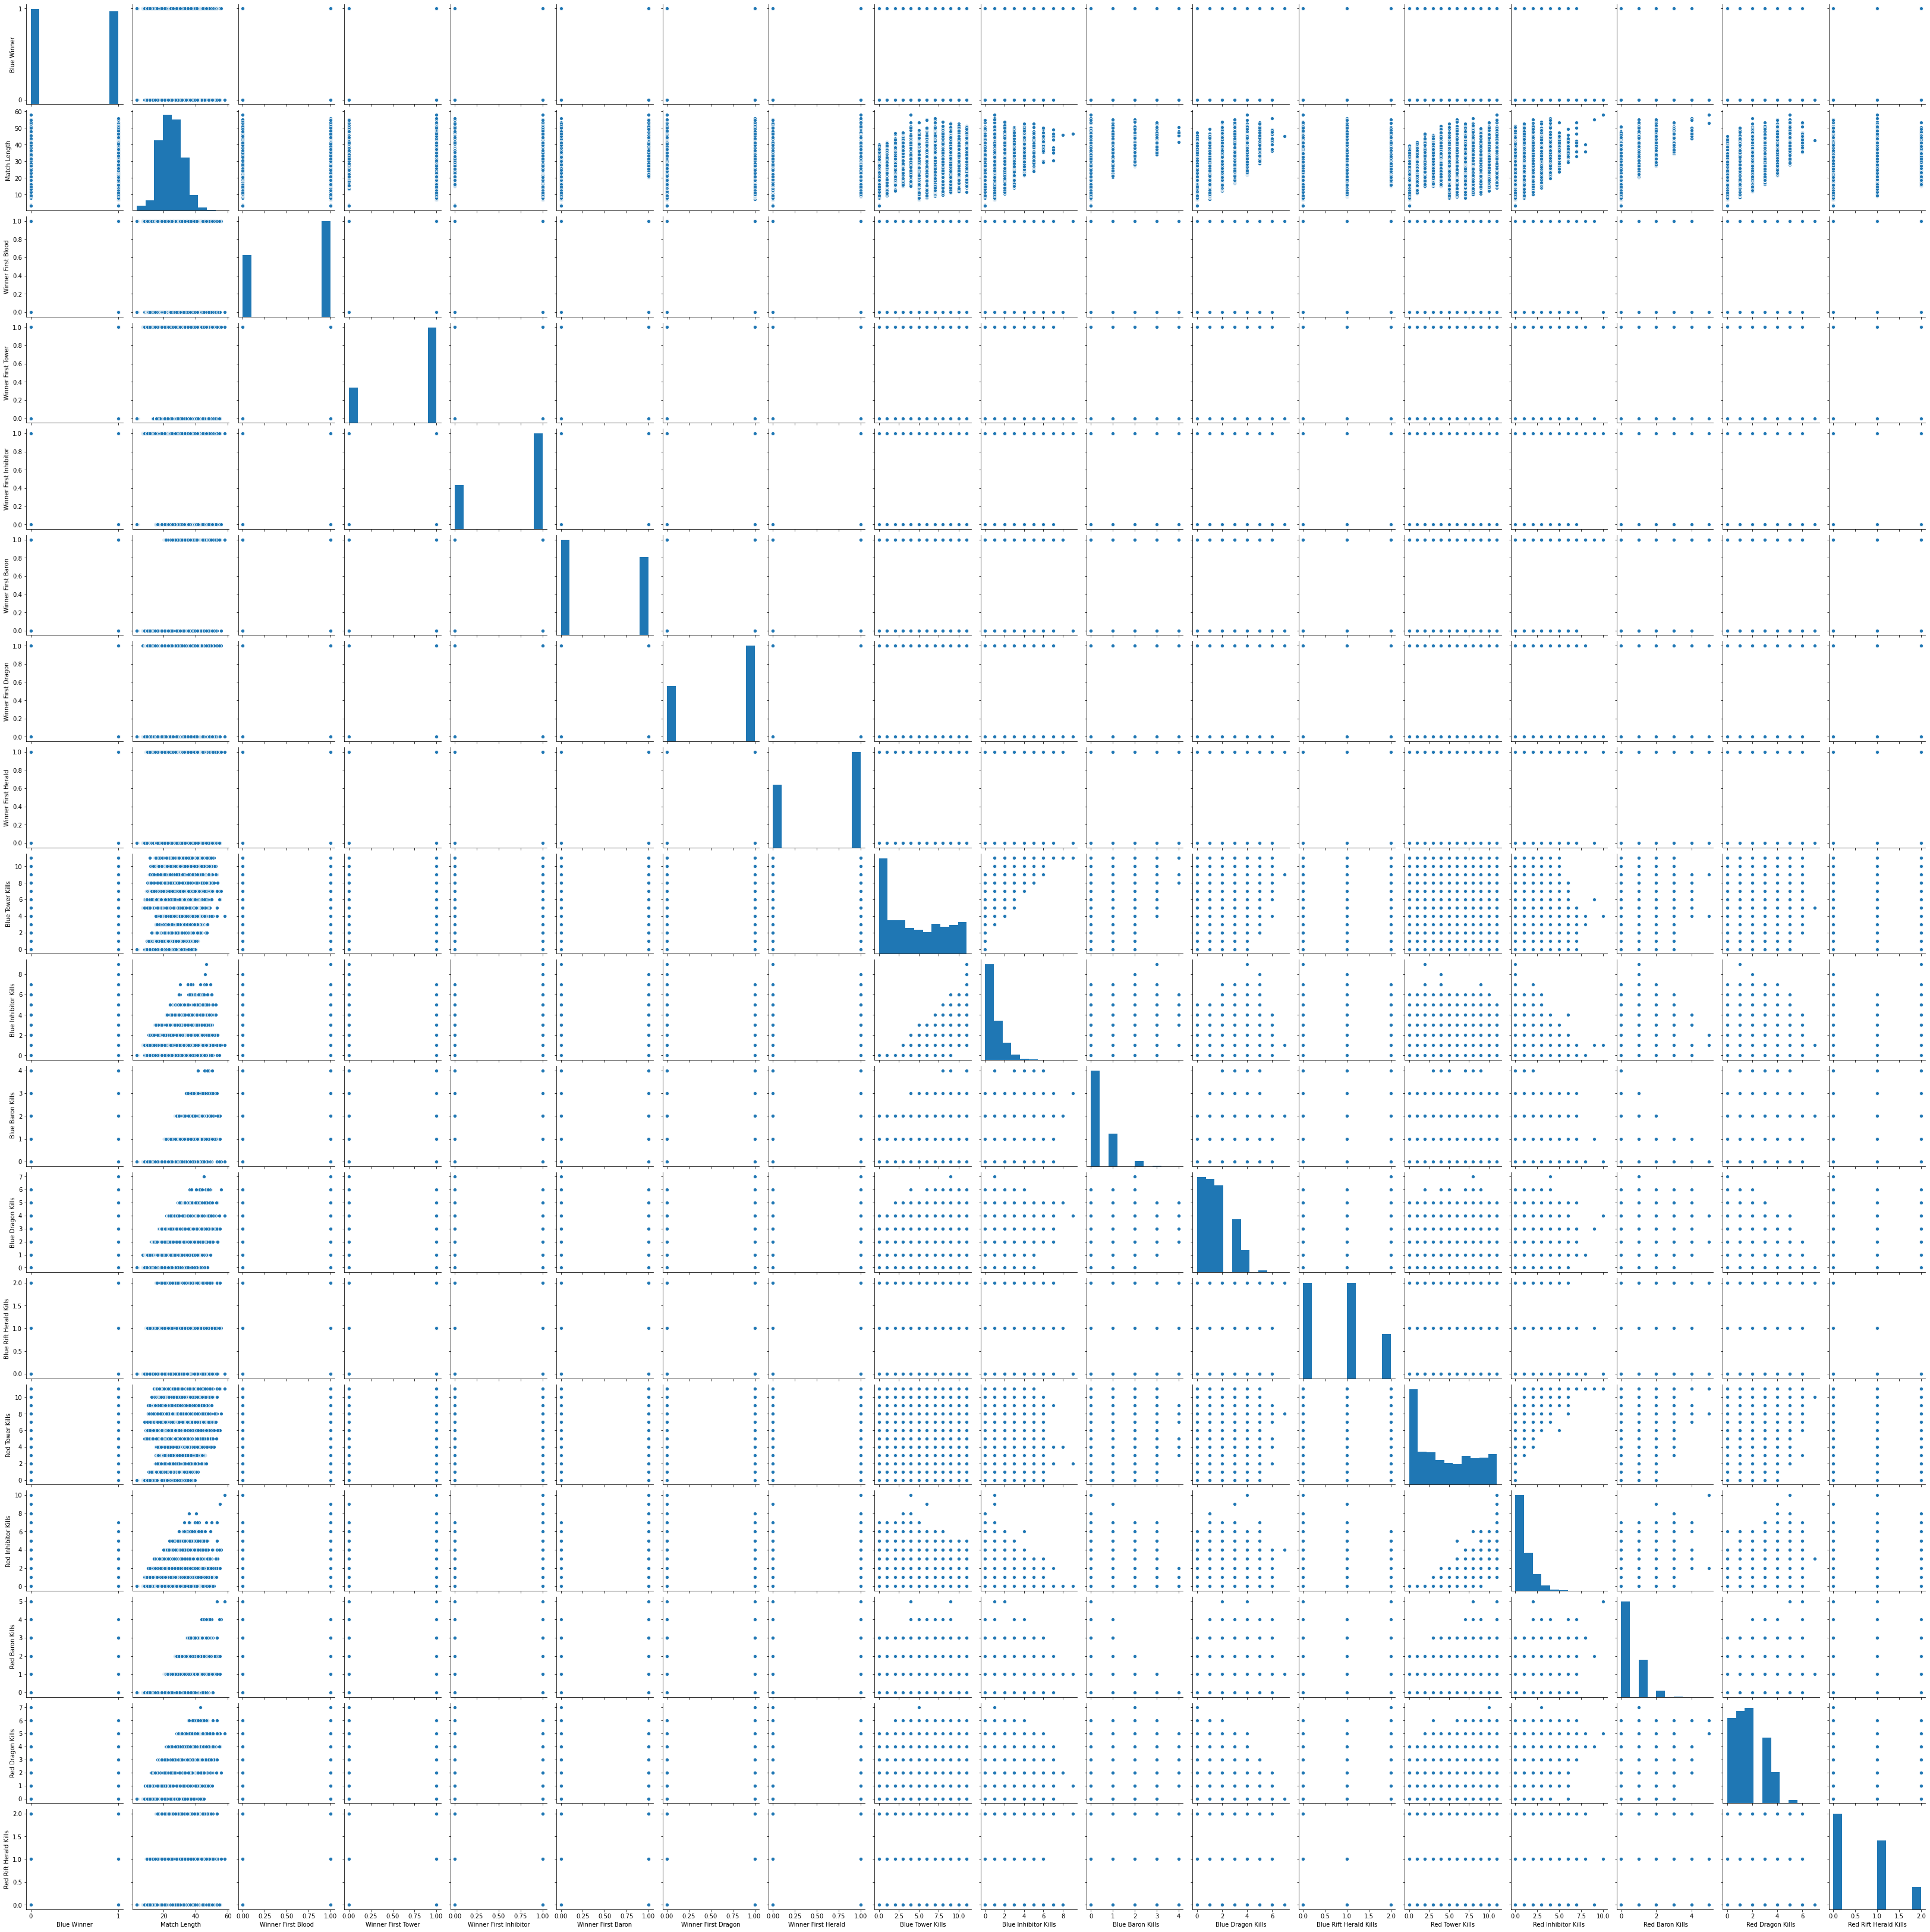

In [18]:
sns.pairplot(df)

In [7]:
def rmse(actuals, preds):
    return np.sqrt(((actuals - preds) ** 2).mean())

In [8]:
rf = RandomForestClassifier(n_estimators = 100, max_features = 3, n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(max_features=3, n_jobs=-1)